<a href="https://colab.research.google.com/github/kimberley-faria/implicit-hate-detection/blob/main/implicit_hate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup a git repo in your google drive - https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

(I did this in a separate notebook, so I can keep this one free of git commit/push etc commands)

In [1]:
# if local
!conda activate cs685

/bin/bash: conda: command not found


In [2]:
BASE_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection'
DATA_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-corpus'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import sys
os.path.dirname(sys.executable)

'/usr/bin'

In [5]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = BASE_PATH
else:
    base_path = r'C:\Users\faria\PycharmProjects\685\project\implicit-hate-detection'
    DATA_PATH = r'C:\Users\faria\PycharmProjects\685\project\data\implicit-hate-corpus-nov-2021\implicit-hate-corpus'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


switch to the git repo in your drive

In [6]:
%cd $base_path
# !git checkout 5-bert-baselines-bin-classification-hate-non-hate

/content/drive/.shortcut-targets-by-id/1S8UITZ4wcfheudaDPm55HK4b4g-PPNuD/685-NLP-Project/implicit-hate-detection


In [7]:
# !git status

install requirements from repo 

In [8]:
# for colab, use venv if in local
!pip install -r requirements.txt
!pip3 install emoji

load the helper and dataloader files

In [9]:
%load implicit_hate_dataloader/dataloader.py    
%load implicit_hate_dataloader/helpers.py

In [10]:
import torch
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla P100-PCIE-16GB, n_gpu: 1


In [11]:
import numpy as np
import random
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import os


def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
      torch.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
      os.environ['PYTHONHASHSEED'] = str(seed)
      # safe to call this function even if cuda is not available
    if is_tf_available():
      import tensorflow as tf
      tf.random.set_seed(seed)

set_seed(70)

In [12]:
data_path = DATA_PATH
dataset_filename = {
    # post (str)
    # class (str): high-level label in {`explicit_hate`,`implicit_hate`,`not_hate`}
    "stage-1": os.path.join(data_path, "implicit_hate_v1_stg1_posts.tsv"),

    # post (str)
    # class (str): fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`}
    # extra_implicit_class: (str) A secondary fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`, **None**}
    "stage-2": os.path.join(data_path, "implicit_hate_v1_stg2_posts.tsv"),

    # post (str)
    # target: (str) Free-text annotation for the group being targeted (e.g. `Black people`, `Immigrants`, etc.)
    # implied_statement: (str) Free-text annotation for the implicit or hidden underlying meaning of the post made
    # explicit (e.g. `people in minority groups are all in gangs`)
    "stage-3": os.path.join(data_path, "implicit_hate_v1_stg3_posts.tsv")
}

In [13]:
from implicit_hate_dataloader.dataloader import Stage1Dataset, Stage2Dataset
from torch.utils.data import DataLoader

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np

implicit_hate_dataset = Stage2Dataset(dataset_filename["stage-2"], drop_other=True, bertweet=True)

labels = implicit_hate_dataset.implicit_classes
# splitting into train and test set
train_idx, test_idx= train_test_split(np.arange(len(labels)), test_size=0.2, shuffle=True, stratify=labels)
print(len(labels), len(train_idx), len(test_idx))
train_idx.sort()
print(np.arange(len(labels)))
print(train_idx)

# splitting into train and val set from train indices 
train_labels = list(map(labels.__getitem__, train_idx))
train_idx, val_idx= train_test_split(train_idx, test_size=0.25, shuffle=True, stratify=train_labels)
print(len(train_idx), len(val_idx))

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=train_sampler)

# test_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=test_sampler)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


6266 5012 1254
[   0    1    2 ... 6263 6264 6265]
[   0    1    2 ... 6260 6262 6265]
3759 1253


In [15]:
# Confirming type is tensor
text, _, _, input_ids, attention_masks, labels, _ = next(iter(train_dataloader))
print(type(input_ids), type(attention_masks), type(labels))

print(text)

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
(' if you\'re white  you don\'t need to  " join " " anything . your skin is your uniform . have white children and teach the our culture "', "it's mexifornia, land of hemp fields and socialistsvery anti-citizen and pro-illegals", 'close border, or bring our soldiers back home to protect the taxpayers!', ': and as poor as they are  the predominantly white areas are still safer .', 'may he rest in peace . i didnt know him  i bet he was a good man . stood for what was right  the white race .', "so is the white hating  jew hating cult  the nation of islam . what's your point ?", ' european  " refugee " " crisis worsens #wakeupamerica #whitelivesmatter "', 'it seems people are willing to sell the future of western children for a momentary feeling of misguided moral superiority .')


In [16]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

import numpy as np
# function to get validation accuracy
def get_validation_performance(model, val_idx, config, epoch, dataset):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    validation_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=sampler)

    total_correct = 0


    class_names=['white_grievance', 'incitement', 'inferiority', 'irony', 'stereotypical', 'threatening']
    posts = []
    gt_labels = []
    pred_labels = []

    predicted = []
    labels = []

    for batch in validation_dataloader:

      input_id_tensors = batch[3]
      input_mask_tensors = batch[4]
      label_tensors = batch[5]
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
        predicted.append(pred_flat)
        labels.append(labels_flat) 

        if dataset == "test":
          for i, (text, implicit_class, _, _, _, label, _) in enumerate(zip(*batch)):
            posts.append(text)
            gt_labels.append(implicit_class)
            pred_labels.append(class_names[pred_flat[i]])


    if dataset == "test":
      analysis_dict = {
          "post": posts,
          "gt_labels": gt_labels,
          "pred_labels": pred_labels
      }
      pd.DataFrame.from_dict(analysis_dict).to_csv("analysis_implicit_hate_detection_multi_class_bertweet_and_sarc.csv")       

        
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_idx)
    final_score = precision_recall_fscore_support(predicted, labels, average='macro')
    class_names=['white_grievance', 'incitement', 'inferiority', 'irony', 'stereotypical', 'threatening']
    wandb.log({f"conf_mat_{dataset}_{epoch}" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels, preds=predicted,
                        class_names=class_names)})
    cm = confusion_matrix(labels, predicted, labels=[0, 1, 2, 3, 4, 5])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=class_names)
    disp.plot()

    wandb.log({f"conf_mat_matplotlib_{dataset}_{epoch}": plt})
    plt.show()

    return avg_val_accuracy, final_score

In [17]:
!wandb login

wandb: Currently logged in as: kfaria (umass-iesl-is). Use `wandb login --relogin` to force relogin


In [18]:
import wandb

# hyperparameters used in original paper
sweep_config = {
    "name": "implicit_hate_detection_multi_class_bertweet_and_sarc",
    "method" : "grid",
    "parameters" : {
        "batch_size": {
            "values" : [8]
        },
        "learning_rate" : {
            "values": [4e-5]
        },
        "random_seed" : {
          "values": [69]    
        },

        "epochs" : {
            "values" : [3]
        },
        "epsilon": {
            "values" : [1e-8]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, entity="umass-iesl-is", project="bertweet-sarc-implicit")
# sweep_id = "gwbynpx8"

Create sweep with ID: ohybvldp
Sweep URL: https://wandb.ai/umass-iesl-is/bertweet-sarc-implicit/sweeps/ohybvldp


In [19]:
from transformers import AutoModelForSequenceClassification, AdamW, BertConfig

def train():
    with wandb.init() as run:
        config = wandb.config
        
        model = AutoModelForSequenceClassification.from_pretrained(
        "./bertweet_then_sarc_final",
        num_labels = 6, # The number of output labels.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        )

        # Tell pytorch to run this model on the GPU.
        model.cuda()


        optimizer = AdamW(model.parameters(),
                        lr = config["learning_rate"], # args.learning_rate - default is 5e-5
                        eps = config["epsilon"] # args.adam_epsilon  - default is 1e-8
                        )
        wandb.watch(model, log="all")

        set_seed(config['random_seed'])
        best_val = 0

        for epoch_i in range(0, config["epochs"]):
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, config["epochs"]))
            print('Training...')

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode.
            model.train()

            # For each batch of training data...
            train_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=train_sampler)

            for batch_idx, batch in enumerate(train_dataloader):

                input_id_tensors = batch[3]
                input_mask_tensors = batch[4]
                label_tensors = batch[5]

                # Move tensors to the GPU
                b_input_ids = input_id_tensors.to(device)
                b_input_mask = input_mask_tensors.to(device)
                b_labels = label_tensors.to(device)

                # Clear the previously calculated gradient
                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Update parameters and take a step using the computed gradient.
                optimizer.step()
                wandb.log({
                    "batch_loss": loss.item(),
                    "batch": batch_idx
                })
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set. Implement this function in the cell above.
            print(f"Total loss: {total_train_loss}")
            val_acc, (val_precision, val_recall, val_f1, val_hash) = get_validation_performance(model, val_idx, config, epoch_i, "val")

            if val_acc > best_val:
              best_val = val_acc
              best_model = model
              best_lr = config["learning_rate"]
              best_randomseed = config["random_seed"]
              torch.save(model.state_dict(), 'multiclass-bertweet-then-sarc-best-model-parameters_analysis.pt')
              wandb.run.summary["best_lr"] = best_lr
              wandb.run.summary["best_randomseed"] = best_randomseed
              wandb.run.summary["best_val"] = best_val

            print(val_precision, val_recall, val_f1)
            print(f"Validation accuracy: {val_acc}")

            wandb.log({
                "loss": total_train_loss, 
                "epoch": config["epochs"], 
                "val_acc": val_acc,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1
                })
            
        print("")
        print("Training complete!")

        test_acc, (test_precision, test_recall, test_f1, test_hash) = get_validation_performance(best_model, test_idx, config, 0, "test")
        print(test_precision, test_recall, test_f1)
        print(f"Test accuracy: {test_acc}")
        wandb.log({
            "test_acc": test_acc,
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1
            })

        # torch.save(model.state_dict(), "model.h5")
        # wandb.save('model.h5')

wandb: Agent Starting Run: 0mz5kj7k with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 69
wandb: Currently logged in as: kfaria (umass-iesl-is). Use `wandb login --relogin` to force relogin


Some weights of the model checkpoint at ./bertweet_then_sarc_final were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./bertweet_then_sarc_final and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.o


======== Epoch 1 / 3 ========
Training...
Total loss: 616.7810695171356


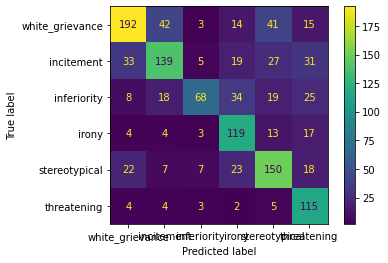

0.639534117249743 0.6360323341060314 0.6170679480948306
Validation accuracy: 0.6249002394253791

======== Epoch 2 / 3 ========
Training...
Total loss: 413.48815381526947


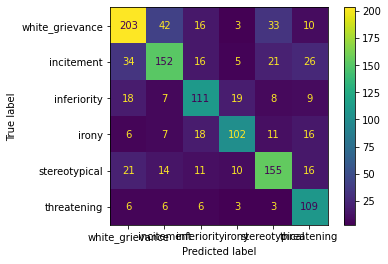

0.6741466790860576 0.6617417198204499 0.6638470355880982
Validation accuracy: 0.6640063846767758

======== Epoch 3 / 3 ========
Training...
Total loss: 273.89580872654915


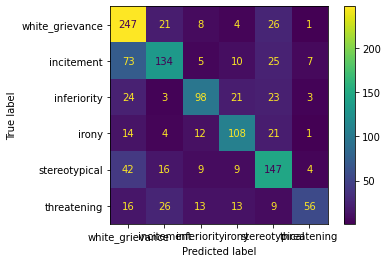

0.6075860802758092 0.6574092361507862 0.6187888591621347
Validation accuracy: 0.6304868316041501

Training complete!


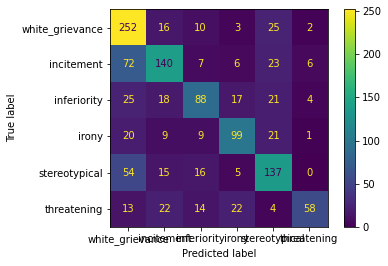

0.5900482341413331 0.647791198308146 0.604479729396333
Test accuracy: 0.6172248803827751


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,▇██▆▇▆▅▅▆▄▄▄▆▂▄▄▅▇▅▆▅▆▃▅▄▃▂▃▃▄▅▄▁▅▂▂▄▂▅▂
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▂
val_f1,▁█▁
val_precision,▄█▁


In [20]:
count = 1 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count, entity="umass-iesl-is", project="bertweet-sarc-implicit")